<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=center>Introduction to Anomaly Detection in Time Series with Keras</h2>


## Task 1: Project Overview and Import Libraries

In [19]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.1.0


## Task 2: Load and Inspect the S&P 500 Index Data

[Data Source](https://www.kaggle.com/pdquant/sp500-daily-19862018): S&P500 Daily Prices 1986 - 2018

In [32]:
df = pd.read_csv("S&P_500_Index_Data.csv")
df.head()

,date,close
0,02-Jan-86,209.59
1,03-Jan-86,210.88
2,06-Jan-86,210.65
3,07-Jan-86,213.80
4,08-Jan-86,207.97


In [33]:
df.shape

(8192, 2)

In [34]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = df.date,y = df.close, mode = "lines", name = "close"))
fig.update_layout(showlegend=True)
fig.show()

## Task 3: Data Preprocessing

In [35]:
train_size = int(len(df) * 0.8)
test_size = int(len(df)) - train_size
train, test = df.iloc[0:train_size,:], df.iloc[train_size:train_size+test_size,:]
print((train.shape), (test.shape))

(6553, 2) (1639, 2)


In [36]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(train[["close"]])

train["close"] = scaler.transform(train[["close"]])
test["close"] = scaler.transform(test[["close"]])

In [37]:
train.columns

Index(['date', 'close'], dtype='object')

## Task 4: Create Training and Test Splits

In [38]:
def create_sequences(x, y, timesteps = 1):
    Xs, ys = [], []
    for i in range(len(x) - timesteps):
        Xs.append(x.iloc[i:(i+timesteps)].values)
        ys.append(y.iloc[i+timesteps])
    return np.array(Xs), np.array(ys)

In [62]:
timesteps = 30
X_train, y_train = create_sequences(train["close"], train["close"], timesteps = timesteps)
X_test, y_test = create_sequences(test["close"], test["close"], timesteps = timesteps)
y_train = y_train.reshape(-1, 1)
X_train = X_train.reshape(6523, 30,1)
X_test = X_test.reshape(1609, 30,1)
y_test = y_test.reshape(-1,1)

In [61]:
print(X_test.shape)
print(y_train.shape)

(1609, 30)
(6523, 1)


## Task 5: Build an LSTM Autoencoder

In [46]:
timesteps = X_train.shape[1]
num_features = X_train.shape[2]

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

model = Sequential([
    LSTM(128, input_shape = (timesteps, num_features)),
    Dropout(0.2),
    RepeatVector(timesteps),
    LSTM(128 ,return_sequences = True),
    Dropout(0.2),
    TimeDistributed(Dense(num_features))
])
model.compile(loss="mae", optimizer="adam")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 30, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
________________________________________________

## Task 6: Train the Autoencoder

In [52]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 3, mode = "min")
history = model.fit(
    X_train, y_train,
    epochs = 100,
    batch_size = 32,
    validation_split = 0.1,
    callbacks = [es],
    shuffle = False
)
history

Train on 5870 samples, validate on 653 samples
Epoch 1/100
5870/5870 [==============================] - 19s 3ms/sample - loss: 0.1509 - val_loss: 0.2013
Epoch 2/100
5870/5870 [==============================] - 15s 3ms/sample - loss: 0.1133 - val_loss: 0.1061
Epoch 3/100
5870/5870 [==============================] - 15s 3ms/sample - loss: 0.0894 - val_loss: 0.0599
Epoch 4/100
5870/5870 [==============================] - 15s 3ms/sample - loss: 0.0795 - val_loss: 0.0398
Epoch 5/100
5870/5870 [==============================] - 15s 3ms/sample - loss: 0.0714 - val_loss: 0.0631
Epoch 6/100
5870/5870 [==============================] - 15s 3ms/sample - loss: 0.0775 - val_loss: 0.0444
Epoch 7/100
5870/5870 [==============================] - 16s 3ms/sample - loss: 0.0717 - val_loss: 0.0330
Epoch 8/100
5870/5870 [==============================] - 15s 3ms/sample - loss: 0.0751 - val_loss: 0.0456
Epoch 9/100
5870/5870 [==============================] - 16s 3ms/sample - loss: 0.0763 - val_loss: 0.0434

## Task 7: Plot Metrics and Evaluate the Model

In [58]:
X_train_pred = model.predict(X_train)

train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis = 1), columns = ["Error"])
train_mae_loss

,Error
0,0.510914
1,0.511408
2,0.512946
3,0.515017
4,0.513823
...,...
6518,0.092893
6519,0.087038
6520,0.093560
6521,0.067472


In [63]:
model.evaluate(X_test, y_test)

1609/1609 [==============================] - 2s 952us/sample - loss: 0.2997


0.2997494750025852

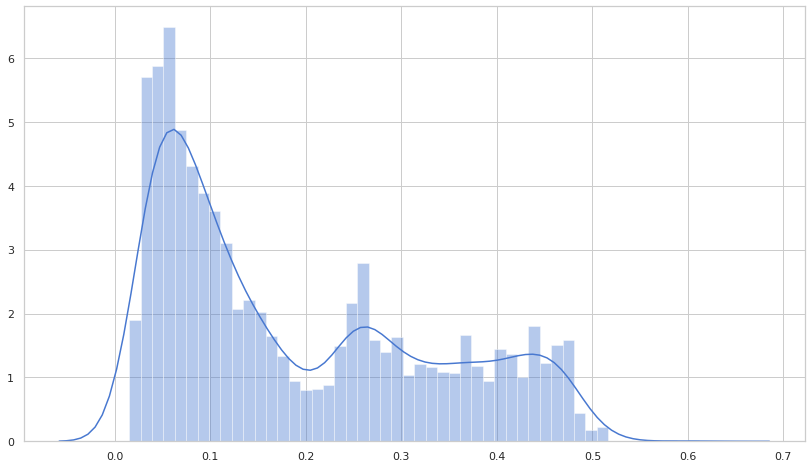

In [64]:
sns.distplot(train_mae_loss, bins = 50, kde = True)

In [65]:
threshold = 0.6

# Test Data

In [67]:
X_test_pred = model.predict(X_test)
test_mae = np.mean(np.abs(X_test_pred - X_test), axis = 1)

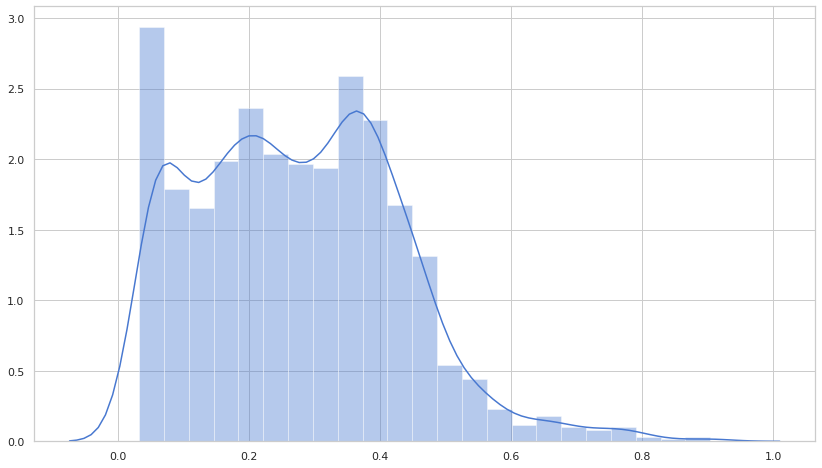

In [69]:
sns.distplot(test_mae)

## Task 8: Detect Anomalies in the S&P 500 Index Data

In [72]:
test_score_df = pd.DataFrame(test[timesteps:])
test_score_df["loss"] = test_mae
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df.loss >test_score_df.threshold
test_score_df['close'] = test[timesteps:].close

In [74]:
test_score_df

,date,close,loss,threshold,anomaly
6583,08-Feb-12,1.216856,0.062708,0.6,False
6584,09-Feb-12,1.221625,0.064258,0.6,False
6585,10-Feb-12,1.199313,0.064334,0.6,False
6586,13-Feb-12,1.221194,0.055173,0.6,False
6587,14-Feb-12,1.218150,0.055719,0.6,False
...,...,...,...,...,...
8187,25-Jun-18,4.493228,0.566041,0.6,False
8188,26-Jun-18,4.507583,0.616114,0.6,True
8189,27-Jun-18,4.451431,0.629351,0.6,True
8190,28-Jun-18,4.491406,0.662492,0.6,True


In [78]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[timesteps:].date, y=test_score_df.loss, mode = "lines", name = "Test Loss"))
fig.add_trace(go.Scatter(x=test[timesteps:].date, y=test_score_df.threshold, mode = "lines", name = "Threshold"))
fig.update_layout(showlegend=True)
fig.update_layout(showlegend=True)
fig.show()

In [80]:
anomalies = test_score_df[test_score_df.anomaly ==True]
anomalies

,date,close,loss,threshold,anomaly
7474,25-Aug-15,2.457439,0.674271,0.6,True
7475,26-Aug-15,2.632149,0.749474,0.6,True
7476,27-Aug-15,2.745147,0.665134,0.6,True
8091,06-Feb-18,4.440671,0.748892,0.6,True
8092,07-Feb-18,4.408365,0.765130,0.6,True
8093,08-Feb-18,4.167127,0.774857,0.6,True
8094,09-Feb-18,4.259514,0.904079,0.6,True
8095,12-Feb-18,4.346869,0.902964,0.6,True
8096,13-Feb-18,4.363501,0.840250,0.6,True
8097,14-Feb-18,4.449035,0.798435,0.6,True


In [86]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[timesteps:].date, y=scaler.inverse_transform(test[timesteps:].close), mode = "lines", name = "Test Loss"))
fig.add_trace(go.Scatter(x=anomalies.date, y=scaler.inverse_transform(anomalies.close), mode = "markers", name = "Anomalies"))
fig.update_layout(showlegend=True)
fig.update_layout(showlegend=True)
fig.show()